In [1]:
### Load the cleaned up files of co-eQTL mapping from the single- datasetd (see previous script)
### Apply multiple testing to the single-dataset files and save the significant co-eQTLs and p-value thresholds

# Libraries

In [4]:
source('MS0_Libraries.r')

Warning message in read.table(file = file, header = header, sep = sep, quote = quote, :
“incomplete final line found by readTableHeader on '../conda_environment/Environment_Configs.csv'”


[1] "/home/icb/corinna.losert/miniconda3/envs/scgrn_R_4_1//lib/R/library"


Loading required package: limma

Loading required package: mgcv

Loading required package: nlme

This is mgcv 1.9-1. For overview type 'help("mgcv-package")'.

Loading required package: genefilter

Loading required package: BiocParallel

corrplot 0.95 loaded

Loading required package: viridisLite


Attaching package: ‘purrr’


The following object is masked from ‘package:data.table’:

    transpose



Attaching package: ‘MASS’


The following object is masked from ‘package:genefilter’:

    area


The following object is masked from ‘package:biomaRt’:

    select



Attaching package: ‘dplyr’


The following object is masked from ‘package:MASS’:

    select


The following object is masked from ‘package:nlme’:

    collapse


The following objects are masked from ‘package:data.table’:

    between, first, last


The following object is masked from ‘package:biomaRt’:

    select


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked 

In [5]:
library(stringi)

In [6]:
library(biomaRt)

# Parameters

In [25]:
## Select dataset and cell-type for which to execute

In [26]:
dataset = 'oneK1K'

In [27]:
dataset_result = 'oneK1K'

In [28]:
cell_type = 'CD4_T'

In [29]:
### Which co-eQTL results (final-mapping: co_qtls_decision_tree; or initial mapping in evaluation phase: co_qtls_sceqtlgen )

In [30]:
coeqtl_results_path = 'co_qtls_decision_tree/'

# co_qtls_sceqtlgen ,co_qtls_T1000

In [31]:
### Path to the co-EQTL Files

In [32]:
data_path = '../data/current/coeqtl_mapping/'

In [ ]:
### Path to the eQTL mapping files (from sceQTLGen)

In [33]:
data_path_eqtl = '../data/current/eqtl_mapping/'

In [34]:
eqtl_results = 'sc_eqtlgen_final'

In [ ]:
### Path to save files to 

In [35]:
result_path = '../results/current/F3/'

In [36]:
result_path_analysis = paste0( "../data/current/coeqtl_mapping/", coeqtl_results_path , "analysis_", dataset_result, "/", cell_type, "/")

In [37]:
result_path_analysis

[1] "../data/current/coeqtl_mapping/co_qtls_decision_tree/analysis_oneK1K/CD4_T/"

In [38]:
###  Path to meta-data

In [39]:
data_path_meta = '../data/current/meta-data'

In [ ]:
### Parameters for multiple testing correction

In [40]:
n_sample_filter = TRUE   # define whether to filter tests based on minimum number of samples 

In [41]:
n_sample_structure = data.frame( dataset = c('oneK1K', 'multiome', 'Franke_v3', 'Franke_v2', 'wijst'),
                                thres = c(102,12,4, 10,4))     # minimum number of sample for test to be considered

In [42]:
snp_filter = ''

# Functions

In [2]:
source('MS1_Functions.r')

# Data

## Load the initial list of genes to test

In [ ]:
### Load all the genes that passed the decision tree filter

In [45]:
gene_list_input = fread(paste0(data_path, coeqtl_results_path , '/correlation_input/', 'F11_Decision_Tree_Geneswg3_', dataset,'_' ,  cell_type, '.Qced.Normalized.SCs.Rds.tsv'))

In [46]:
head(gene_list_input)

x
<chr>
A1BG
A2M
AAGAB
AAK1
AAMDC
AAMP


In [47]:
colnames(gene_list_input) = 'x'

In [48]:
nrow(gene_list_input)

[1] 7503

## Load the SNP eGene mapping (cis-eQTLs from sceQTLgen)

In [49]:
### Provided by Marc-Jan

In [54]:
snp_gene_mapping = read.csv(paste0(data_path_eqtl, eqtl_results , '/' , cell_type, '_snp_egene_mapping.csv'))

In [55]:
nrow(snp_gene_mapping)

[1] 6795

In [56]:
head(snp_gene_mapping,2)

,X,feature_id,snp_id,feature_start,feature_end,p_value,beta
,<int>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>
1,0,GSTM3,1:109740350:G:T,109733932,109741038,5.311981e-277,-1.1703583
2,1,GSTM3,1:109731286:G:T,109733932,109741038,1.872347e-74,-0.7292481


In [57]:
snp_gene_mapping = unique(snp_gene_mapping[,c('feature_id', 'snp_id')])
colnames(snp_gene_mapping) = c('gene', 'snp')

In [60]:
### Filter on the egenes also left after decision tree

In [61]:
snp_gene_mapping_filtered = snp_gene_mapping[snp_gene_mapping$gene %in% gene_list_input$x,]

In [62]:
nrow(snp_gene_mapping_filtered )

[1] 4350

In [63]:
## Calculate amount of expected gene pairs

In [64]:
(((length(unique(snp_gene_mapping_filtered$gene)) * length(unique(snp_gene_mapping_filtered$gene))) - length(unique(snp_gene_mapping_filtered$gene)))/2) + 
((nrow(gene_list_input) -length(unique(snp_gene_mapping_filtered$gene))) * length(unique(snp_gene_mapping_filtered$gene)))


#(((#egenes * # egenes) - #egenes)/2) + ((#genes - #egenes)* #egenes)

[1] 18182337

In [65]:
### Check the actual amount of gene-pairs

## Load info about ribosomal/ mitochondrial genes

In [67]:
### Load the annotation of ribosomal and mitochondrial genes

In [68]:
ribosomal_genes = read.csv(paste0(data_path_meta , '/ribosomal_genes.txt.gz') ,sep = '\t')

In [69]:
head(ribosomal_genes,2)

,Gene.stable.ID,Transcript.stable.ID,Gene.name,Gene.start..bp.,Gene.end..bp.,Chromosome.scaffold.name,Gene.Synonym
,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>
1,ENSG00000164163,ENST00000296577,ABCE1,145098288,145129524,4,OABP
2,ENSG00000164163,ENST00000296577,ABCE1,145098288,145129524,4,RLI


In [70]:
ribosomal_genes = unique(ribosomal_genes$Gene.name)

In [71]:
head(ribosomal_genes)

[1] "ABCE1" "ABCF1" "APEX1" "APOD"  "ASCC2" "ASCC3"

In [72]:
### Mitochondrial Genes

In [73]:
mitochondrial_genes = read.csv(paste0(data_path_meta , '/mitochondrial_genes.txt') ,sep = '\t')

In [74]:
head(mitochondrial_genes,2)

,Gene.stable.ID,Gene.stable.ID.version,Transcript.stable.ID,Transcript.stable.ID.version,Chromosome.scaffold.name,Gene.start..bp.,Gene.end..bp.
,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>
1,ENSG00000198888,ENSG00000198888.2,ENST00000361390,ENST00000361390.2,MT,3307,4262
2,ENSG00000198763,ENSG00000198763.3,ENST00000361453,ENST00000361453.3,MT,4470,5511


In [75]:
### convert ENSG to SYMBOL

In [76]:
mitochondrial_genes_convert <- bitr(unique(mitochondrial_genes$Gene.stable.ID), 
                  fromType = "ENSEMBL", 
                  toType = "SYMBOL", 
                  OrgDb = org.Hs.eg.db)

'select()' returned 1:many mapping between keys and columns

Warning message in bitr(unique(mitochondrial_genes$Gene.stable.ID), fromType = "ENSEMBL", :
"2.14% of input gene IDs are fail to map..."


In [77]:
head(mitochondrial_genes_convert,2)

,ENSEMBL,SYMBOL
,<chr>,<chr>
1,ENSG00000198888,ND1
2,ENSG00000198763,ND2


In [78]:
mitochondrial_genes  = unique(mitochondrial_genes_convert$SYMBOL)

In [79]:
head(mitochondrial_genes)

[1] "ND1"  "ND2"  "COX1" "COX2" "ATP8" "ATP6"

In [80]:
### Combine

In [81]:
rb_mt_genes = unique(c(ribosomal_genes, mitochondrial_genes))

In [82]:
head(rb_mt_genes,2)

[1] "ABCE1" "ABCF1"

## Load the co-eQTL results

In [ ]:
### Load the co-eQTL mapping file of the selected cell-type and dataset

In [83]:
coeqtl_results = fread(paste0(data_path, coeqtl_results_path , '/', dataset, '/', cell_type, '/qtl_results_all_unqid.csv.gz'), header = TRUE)

In [84]:
nrow(coeqtl_results)

[1] 150181698

In [85]:
head(coeqtl_results)

V1,feature_id,snp_id,p_value,beta,beta_se,empirical_feature_p_value,feature_chromosome,feature_start,feature_end,⋯,coeGene,coQTL,snp_position,closeGenes,z_score,triplet,n_samples,n_e_samples,gene1,gene2
<int>,<chr>,<chr>,<dbl>,<lgl>,<lgl>,<lgl>,<int>,<int>,<int>,⋯,<chr>,<chr>,<int>,<lgl>,<dbl>,<chr>,<int>,<int>,<chr>,<chr>
0,A1BG_A2M,12:8942630:T:C,0.015607427,NA,NA,NA,12,9067664,9116229,⋯,A1BG,12:8942630:T:C;A2M_A1BG,8942630,FALSE,2.4227677,A1BG_A2M;12:8942630:T:C,848,848,A2M,A1BG
1,A1BG_A2M,12:8971336:T:C,0.001673528,NA,NA,NA,12,9067664,9116229,⋯,A1BG,12:8971336:T:C;A2M_A1BG,8971336,FALSE,-3.1526976,A1BG_A2M;12:8971336:T:C,848,848,A2M,A1BG
2,A1BG_A2M,12:8992460:T:C,0.002398787,NA,NA,NA,12,9067664,9116229,⋯,A1BG,12:8992460:T:C;A2M_A1BG,8992460,FALSE,-3.0448233,A1BG_A2M;12:8992460:T:C,848,848,A2M,A1BG
3,A1BG_A2M,12:9027756:A:G,0.515272692,NA,NA,NA,12,9067664,9116229,⋯,A1BG,12:9027756:A:G;A2M_A1BG,9027756,FALSE,-0.6509177,A1BG_A2M;12:9027756:A:G,848,848,A2M,A1BG
4,A1BG_A2M,12:9157980:T:G,0.492139444,NA,NA,NA,12,9067664,9116229,⋯,A1BG,12:9157980:T:G;A2M_A1BG,9157980,FALSE,-0.6872027,A1BG_A2M;12:9157980:T:G,848,848,A2M,A1BG
5,A1BG_A2M,12:9680928:C:G,0.822040268,NA,NA,NA,12,9067664,9116229,⋯,A1BG,12:9680928:C:G;A2M_A1BG,9680928,FALSE,-0.2249900,A1BG_A2M;12:9680928:C:G,848,848,A2M,A1BG


In [87]:
### Only for Mono/ B: filter out eGenes that don't fall in 5% FDR thres
coeqtl_results = coeqtl_results[coeqtl_results$eGene %in% unique(snp_gene_mapping$gene),]

In [89]:
nrow(coeqtl_results)

[1] 150181698

In [92]:
head(coeqtl_results,2)

V1,feature_id,snp_id,p_value,beta,beta_se,empirical_feature_p_value,feature_chromosome,feature_start,feature_end,⋯,coeGene,coQTL,snp_position,closeGenes,z_score,triplet,n_samples,n_e_samples,gene1,gene2
<int>,<chr>,<chr>,<dbl>,<lgl>,<lgl>,<lgl>,<int>,<int>,<int>,⋯,<chr>,<chr>,<int>,<lgl>,<dbl>,<chr>,<int>,<int>,<chr>,<chr>
0,A1BG_A2M,12:8942630:T:C,0.015607427,NA,NA,NA,12,9067664,9116229,⋯,A1BG,12:8942630:T:C;A2M_A1BG,8942630,FALSE,2.422768,A1BG_A2M;12:8942630:T:C,848,848,A2M,A1BG
1,A1BG_A2M,12:8971336:T:C,0.001673528,NA,NA,NA,12,9067664,9116229,⋯,A1BG,12:8971336:T:C;A2M_A1BG,8971336,FALSE,-3.152698,A1BG_A2M;12:8971336:T:C,848,848,A2M,A1BG


In [93]:
max(coeqtl_results$n_samples)

[1] 1018

In [97]:
summary(coeqtl_results$n_samples)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   16.0   881.0   956.0   922.1   990.0  1018.0 

In [ ]:
### Remove dummy columns

In [102]:
coeqtl_results$V1 = NULL
#coeqtl_results$test1 = NULL
#coeqtl_results$test2 = NULL
#coeqtl_results$test3 = NULL

In [ ]:
### Add cell-type and dataset to file

In [103]:
coeqtl_results$cell_type = cell_type  
coeqtl_results$dataset = dataset

### Define ribosomal and mitochondrial genes

In [105]:
coeqtl_results$is_rb_mt = 0
coeqtl_results$is_rb_mt[(coeqtl_results$eGene %in% rb_mt_genes) |
                            (coeqtl_results$coeGene %in% rb_mt_genes)] = 1

In [106]:
### Save the unfiltered amount of tests

In [107]:
amount_tests_save = coeqtl_results %>% group_by( dataset, cell_type, n_samples, is_rb_mt) %>% summarise(amount_tests_datasets = n())

`summarise()` has grouped output by 'dataset', 'cell_type', 'n_samples'. You
can override using the `.groups` argument.


In [108]:
write.csv(amount_tests_save, paste0(result_path_analysis , 'F3_1_1_Meta_Info_Tests.csv'))

### Filter on only cis-eQTL snps

In [110]:
nrow(coeqtl_results)

[1] 150181698

In [111]:
head(coeqtl_results,2)

feature_id,snp_id,p_value,beta,beta_se,empirical_feature_p_value,feature_chromosome,feature_start,feature_end,ENSG,⋯,closeGenes,z_score,triplet,n_samples,n_e_samples,gene1,gene2,cell_type,dataset,is_rb_mt
<chr>,<chr>,<dbl>,<lgl>,<lgl>,<lgl>,<int>,<int>,<int>,<chr>,⋯,<lgl>,<dbl>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>
A1BG_A2M,12:8942630:T:C,0.015607427,NA,NA,NA,12,9067664,9116229,ENSG00000175899,⋯,FALSE,2.422768,A1BG_A2M;12:8942630:T:C,848,848,A2M,A1BG,CD4_T,oneK1K,0
A1BG_A2M,12:8971336:T:C,0.001673528,NA,NA,NA,12,9067664,9116229,ENSG00000175899,⋯,FALSE,-3.152698,A1BG_A2M;12:8971336:T:C,848,848,A2M,A1BG,CD4_T,oneK1K,0


In [112]:
if(snp_filter == 'cis'){
    coeqtl_results = coeqtl_results[coeqtl_results$snp_id %in% unique(snp_gene_mapping$snp),]
    }
    
    

In [113]:
nrow(coeqtl_results)

[1] 150181698

In [115]:
### Save amount of tests after filtering

In [116]:
amount_tests_save = coeqtl_results %>% group_by( dataset, cell_type, n_samples, is_rb_mt) %>% summarise(amount_tests_datasets = n())

`summarise()` has grouped output by 'dataset', 'cell_type', 'n_samples'. You
can override using the `.groups` argument.


In [117]:
write.csv(amount_tests_save, paste0(result_path_analysis , 'F3_1_1_Meta_Info_Tests', '_', snp_filter, '.csv'))

### Filter based on minimum amount of samples

In [119]:
nrow(coeqtl_results)

[1] 150181698

In [120]:
if(n_sample_filter == TRUE){
    threshold = n_sample_structure$thres[n_sample_structure$dataset == dataset]
    coeqtl_results = coeqtl_results[coeqtl_results$n_samples > threshold,]
    }
    
    

In [121]:
coeqtl_results[coeqtl_results$feature_id ==  'IGHG2_VCPKMT',]

Warning message in cbind(parts$left, chars$ellip_h, parts$right, deparse.level = 0L):
"number of rows of result is not a multiple of vector length (arg 2)"
Warning message in cbind(parts$left, chars$ellip_h, parts$right, deparse.level = 0L):
"number of rows of result is not a multiple of vector length (arg 2)"
Warning message in cbind(parts$left, chars$ellip_h, parts$right, deparse.level = 0L):
"number of rows of result is not a multiple of vector length (arg 2)"
Warning message in cbind(parts$left, chars$ellip_h, parts$right, deparse.level = 0L):
"number of rows of result is not a multiple of vector length (arg 2)"


feature_id,snp_id,p_value,beta,beta_se,empirical_feature_p_value,feature_chromosome,feature_start,feature_end,ENSG,⋯,closeGenes,z_score,triplet,n_samples,n_e_samples,gene1,gene2,cell_type,dataset,is_rb_mt
<chr>,<chr>,<dbl>,<lgl>,<lgl>,<lgl>,<int>,<int>,<int>,<chr>,⋯,<lgl>,<dbl>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>


In [122]:
min(coeqtl_results$n_samples)

[1] 103

In [123]:
nrow(coeqtl_results)

[1] 149928159

In [124]:
### check nas for p-value

In [125]:
nrow(coeqtl_results[is.na(coeqtl_results$p_value),])

[1] 0

In [126]:
### columns within results

In [127]:
sort(colnames(coeqtl_results))

[1] "alpha_param"               "beta"                     
 [3] "beta_param"                "beta_se"                  
 [5] "cell_type"                 "closeGenes"               
 [7] "coeGene"                   "coQTL"                    
 [9] "dataset"                   "eGene"                    
[11] "empirical_feature_p_value" "ENSG"                     
[13] "feature_chromosome"        "feature_end"              
[15] "feature_id"                "feature_start"            
[17] "gene1"                     "gene2"                    
[19] "is_rb_mt"                  "n_e_samples"              
[21] "n_samples"                 "p_value"                  
[23] "snp_id"                    "snp_position"             
[25] "triplet"                   "z_score"

### Multiple Testing 

In [129]:
### Get the amount of tests per eGene
coeqtl_results = coeqtl_results %>% group_by(eGene) %>% mutate(amount_tests_eGene = n())

In [130]:
### Correct for multiple testing per eGene
coeqtl_results$p_val_mt_eGene = coeqtl_results$p_value * coeqtl_results$amount_tests_eGene

In [131]:
### Get the top effect per eGene
top_eGene_effects = coeqtl_results %>% group_by(eGene) %>% dplyr::filter(p_value == min(p_value)) %>% ungroup()

In [132]:
top_eGene_effects = top_eGene_effects %>% group_by(eGene) %>% slice_min(p_value, with_ties = FALSE)

In [133]:
nrow(top_eGene_effects)

[1] 3037

In [134]:
head(top_eGene_effects,3)

feature_id,snp_id,p_value,beta,beta_se,empirical_feature_p_value,feature_chromosome,feature_start,feature_end,ENSG,⋯,triplet,n_samples,n_e_samples,gene1,gene2,cell_type,dataset,is_rb_mt,amount_tests_eGene,p_val_mt_eGene
<chr>,<chr>,<dbl>,<lgl>,<lgl>,<lgl>,<int>,<int>,<int>,<chr>,⋯,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<dbl>
A1BG_RPL8,19:58497199:G:A,9.263029e-06,NA,NA,NA,19,58345178,58353499,ENSG00000121410,⋯,A1BG_RPL8;19:58497199:G:A,990,990,RPL8,A1BG,CD4_T,oneK1K,1,37478,3.471598e-01
A2M_PZP,12:8992460:T:C,3.856050e-23,NA,NA,NA,12,9067664,9116229,ENSG00000126838,⋯,A2M_PZP;12:8992460:T:C,837,837,PZP,A2M,CD4_T,oneK1K,0,97356,3.754096e-18
AAK1_CDIN1,2:69517668:C:T,4.342112e-05,NA,NA,NA,2,69457997,69674349,ENSG00000115977,⋯,AAK1_CDIN1;2:69517668:C:T,852,852,CDIN1,AAK1,CD4_T,oneK1K,0,14994,6.510562e-01


In [137]:
top_eGene_effects$p_val_mt_eGene[top_eGene_effects$p_val_mt_eGene > 1] = 1

In [138]:
### Correct top-effects with q_value

In [139]:
#top_eGene_effects = top_eGene_effects %>% mutate(p_bh = p.adjust(p_val_mt_eGene, method = "BH"))

top_eGene_effects$q_val = qvalue(p = top_eGene_effects$p_val_mt_eGene)$qvalues

#top_eGene_effects$p_bh = qvalue(p = top_eGene_effects$p_val_mt_eGene,pi0 = 1)$qvalues

top_eGene_effects$p_bh =  p.adjust(top_eGene_effects$p_val_mt_eGene, method = "BH")

In [140]:
head(top_eGene_effects,3)

feature_id,snp_id,p_value,beta,beta_se,empirical_feature_p_value,feature_chromosome,feature_start,feature_end,ENSG,⋯,n_e_samples,gene1,gene2,cell_type,dataset,is_rb_mt,amount_tests_eGene,p_val_mt_eGene,q_val,p_bh
<chr>,<chr>,<dbl>,<lgl>,<lgl>,<lgl>,<int>,<int>,<int>,<chr>,⋯,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
A1BG_RPL8,19:58497199:G:A,9.263029e-06,NA,NA,NA,19,58345178,58353499,ENSG00000121410,⋯,990,RPL8,A1BG,CD4_T,oneK1K,1,37478,3.471598e-01,9.798553e-01,9.798553e-01
A2M_PZP,12:8992460:T:C,3.856050e-23,NA,NA,NA,12,9067664,9116229,ENSG00000126838,⋯,837,PZP,A2M,CD4_T,oneK1K,0,97356,3.754096e-18,4.256168e-16,4.256168e-16
AAK1_CDIN1,2:69517668:C:T,4.342112e-05,NA,NA,NA,2,69457997,69674349,ENSG00000115977,⋯,852,CDIN1,AAK1,CD4_T,oneK1K,0,14994,6.510562e-01,1.000000e+00,1.000000e+00


In [141]:
### Get the cutoff p-value
p_val_cutoff_bh = head(top_eGene_effects[top_eGene_effects$p_bh < 0.05,c('p_val_mt_eGene', 'p_bh')] %>% arrange(-p_bh),1)
p_val_cutoff_q = head(top_eGene_effects[top_eGene_effects$q_val < 0.05,c('p_val_mt_eGene', 'q_val')] %>% arrange(-q_val),1)

In [142]:
p_val_cutoff_bh

p_val_mt_eGene,p_bh
<dbl>,<dbl>
0.00266828,0.04941199


In [143]:
## Add the cutoff p-value to the result
coeqtl_results$p_bh_cutoff = p_val_cutoff_bh$p_val_mt_eGene
coeqtl_results$p_q_cutoff = p_val_cutoff_q$p_val_mt_eGene

###  Check for duplicates

In [145]:
coeqtl_results = setDT(coeqtl_results)

In [146]:
dupl_invest =  coeqtl_results[, .(.N), by = .(feature_id, snp_id, dataset, cell_type)]

In [147]:
dupl_invest = dupl_invest[dupl_invest$N >= 2,]

In [148]:
nrow(dupl_invest)  # amount of dupicates

[1] 71691

In [149]:
head(dupl_invest)

feature_id,snp_id,dataset,cell_type,N
<chr>,<chr>,<chr>,<chr>,<int>
A1BG_MZF1-AS1,19:57620738:A:C,oneK1K,CD4_T,2
A1BG_MZF1-AS1,19:57738275:G:C,oneK1K,CD4_T,2
A1BG_MZF1-AS1,19:58357814:C:A,oneK1K,CD4_T,2
A1BG_MZF1-AS1,19:58358468:AGT:A,oneK1K,CD4_T,2
A1BG_MZF1-AS1,19:58497199:G:A,oneK1K,CD4_T,2
A1BG_MZF1-AS1,19:58501767:G:A,oneK1K,CD4_T,2


In [150]:
#### put togehter identifier of duplicates
dupl_invest$triplet = paste0(dupl_invest$snp_id, ';', dupl_invest$feature_id)

In [151]:
### put together identifier for all results
coeqtl_results$triplet = paste0(coeqtl_results$snp_id, ';', coeqtl_results$feature_id)

In [152]:
## Get only unique values (if there are duplictes)

In [153]:
if(nrow(dupl_invest)  > 0){
    ## Previous solution
    # coeqtl_results = coeqtl_results %>% group_by(feature_id, snp_id,   cell_type, dataset, feature_chromosome, feature_end, feature_start) %>% summarise(beta_se = max(beta_se), p_value = mean(p_value),beta = mean(beta)
    
    coeqtl_results_un = coeqtl_results[!coeqtl_results$triplet %in% dupl_invest$triplet,]
    coeqtl_results_un$type = 'unique'
    
    coeqtl_results_dupl = coeqtl_results[coeqtl_results$triplet %in% dupl_invest$triplet,]
    coeqtl_results_dupl$eGene = coeqtl_results_dupl$feature_id
    coeqtl_results_dupl$coeGene = coeqtl_results_dupl$feature_id
    coeqtl_results_dupl$type = 'duplicate'
    
    coeqtl_results_dupl=    coeqtl_results_dupl %>% group_by(triplet) %>% mutate(rank = rank(eGene, ties.method = 'first'))
    coeqtl_results_dupl =  coeqtl_results_dupl[ coeqtl_results_dupl$rank == 1,]
    coeqtl_results_dupl$rank = NULL
    
    coeqtl_results = rbind(coeqtl_results_un, coeqtl_results_dupl)
    
    
    }

In [154]:
nrow(coeqtl_results)

[1] 149856468

In [155]:
coeqtl_results = setDT(coeqtl_results)

# Analyze results 

## Check significant triplets with different multiple testing corrections

In [159]:
head(coeqtl_results,2)

feature_id,snp_id,p_value,beta,beta_se,empirical_feature_p_value,feature_chromosome,feature_start,feature_end,ENSG,⋯,gene1,gene2,cell_type,dataset,is_rb_mt,amount_tests_eGene,p_val_mt_eGene,p_bh_cutoff,p_q_cutoff,type
<chr>,<chr>,<dbl>,<lgl>,<lgl>,<lgl>,<int>,<int>,<int>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>
A1BG_A2M,12:8942630:T:C,0.015607427,NA,NA,NA,12,9067664,9116229,ENSG00000175899,⋯,A2M,A1BG,CD4_T,oneK1K,0,97356,1519.477,0.00266828,0.00266828,unique
A1BG_A2M,12:8971336:T:C,0.001673528,NA,NA,NA,12,9067664,9116229,ENSG00000175899,⋯,A2M,A1BG,CD4_T,oneK1K,0,97356,162.928,0.00266828,0.00266828,unique


In [160]:
### Amount of tests per dataset

In [161]:
amount_tests = coeqtl_results %>% group_by( dataset, cell_type) %>% summarise(amount_tests_datasets = n())

`summarise()` has grouped output by 'dataset'. You can override using the
`.groups` argument.


In [162]:
amount_tests

dataset,cell_type,amount_tests_datasets
<chr>,<chr>,<int>
oneK1K,CD4_T,149856468


In [163]:
nrow(coeqtl_results)

[1] 149856468

In [164]:
#### Add to result and correct p-value

In [165]:
coeqtl_results = merge(coeqtl_results, amount_tests[,c( 'dataset', 'cell_type', 'amount_tests_datasets')])

In [166]:
nrow(coeqtl_results)

[1] 149856468

In [167]:
coeqtl_results$p_val_mt = coeqtl_results$p_value *  coeqtl_results$amount_tests_datasets

In [168]:
### Correct with Benjamini hochberg
coeqtl_results = coeqtl_results %>% group_by(dataset, cell_type) %>% mutate(p_val_corrected = p.adjust(p_value, method="BH"))

In [169]:
coeqtl_results$p_value[coeqtl_results$p_value  > 1] = 1 

In [170]:
### Alternative qvalue correction

In [171]:
sum(is.na(coeqtl_results$p_value))

[1] 0

In [175]:
### Significant per dataset (according to BH corrections) - 0.05
coeqtl_results %>% group_by(dataset, cell_type) %>% summarise(amount_sign = sum(p_val_corrected <= 0.05, na.rm = TRUE))

`summarise()` has grouped output by 'dataset'. You can override using the
`.groups` argument.


dataset,cell_type,amount_sign
<chr>,<chr>,<int>
oneK1K,CD4_T,96189


In [176]:
### Significant per dataset (according to BH corrections) - 0.1
coeqtl_results %>% group_by(dataset, cell_type) %>% summarise(amount_sign = sum(p_val_corrected <= 0.1, na.rm = TRUE))

`summarise()` has grouped output by 'dataset'. You can override using the
`.groups` argument.


dataset,cell_type,amount_sign
<chr>,<chr>,<int>
oneK1K,CD4_T,114232


## Analyze structure of co-eQTLs

In [179]:
## only significant results

In [180]:
head(coeqtl_results,2)

cell_type,dataset,feature_id,snp_id,p_value,beta,beta_se,empirical_feature_p_value,feature_chromosome,feature_start,⋯,gene2,is_rb_mt,amount_tests_eGene,p_val_mt_eGene,p_bh_cutoff,p_q_cutoff,type,amount_tests_datasets,p_val_mt,p_val_corrected
<chr>,<chr>,<chr>,<chr>,<dbl>,<lgl>,<lgl>,<lgl>,<int>,<int>,⋯,<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<dbl>
CD4_T,oneK1K,A1BG_A2M,12:8942630:T:C,0.015607427,NA,NA,NA,12,9067664,⋯,A1BG,0,97356,1519.477,0.00266828,0.00266828,unique,149856468,2338874,0.8627429
CD4_T,oneK1K,A1BG_A2M,12:8971336:T:C,0.001673528,NA,NA,NA,12,9067664,⋯,A1BG,0,97356,162.928,0.00266828,0.00266828,unique,149856468,250789,0.5682995


In [181]:
thres = 0.05
column = 'p_value'  # p_val_mt , q_val, p_value = nominal p-value

In [182]:
#coeqtl_results[,column]

In [183]:
### get sign results
sign_results = coeqtl_results[coeqtl_results[,column] < thres,]

In [184]:
sign_results = sign_results[!is.na(sign_results$p_value),]

In [185]:
nrow(sign_results )

[1] 8050384

In [186]:
### Unique gene-pairs
length(unique(sign_results$feature_id))

[1] 3652020

In [187]:
### Unique SNPs
length(unique(sign_results$snp_id))

[1] 7247

In [188]:
### Unique eGenes
length(unique(sign_results$eGene))

[1] 4858

In [189]:
### Unique co _eGenes
length(unique(sign_results$coeGene))

[1] 9315

In [263]:
nrow(sign_results)

[1] 8050384

In [267]:
### Analyze amount of co-egenes per Gene1 + SNP

In [268]:
amount_co_egenes = sign_results %>% group_by( snp_id, eGene) %>% summarise(amount_co_e_genes = n()) ## TBD add: , snp_id

`summarise()` has grouped output by 'snp_id'. You can override using the
`.groups` argument.


In [269]:
head(amount_co_egenes %>% arrange(-amount_co_e_genes),15)

snp_id,eGene,amount_co_e_genes
<chr>,<chr>,<int>
12:56042145:C:G,RPS26,5472
12:56007301:G:A,RPS26,5441
12:56076841:C:T,RPS26,5440
12:56083910:A:T,RPS26,5415
12:55991020:G:A,RPS26,5345
12:55995509:T:C,RPS26,5333
12:56001170:A:G,RPS26,5307
12:56061510:C:T,RPS26,5149
12:56051582:G:A,RPS26,5147


In [270]:
## check out non ribosomal genes
head(amount_co_egenes[!amount_co_egenes$eGene %in% ribosomal_genes,] %>% arrange(-amount_co_e_genes),20)

snp_id,eGene,amount_co_e_genes
<chr>,<chr>,<int>
17:7304878:C:T,EIF5A,3894
17:7303462:G:A,EIF5A,3415
22:42095730:G:T,SMDT1,2162
22:42074313:T:C,SMDT1,2158
6:31353491:T:G,HLA-B,1817
6:166960059:T:G,RNASET2,1698
6:166993145:G:C,RNASET2,1686
5:65541278:C:T,CENPK,1685
6:166978686:C:T,RNASET2,1680


In [271]:
#ribosomal_genes

In [272]:
nrow(unique(amount_co_egenes[,c('eGene', 'snp_id')]))

[1] 25077

In [273]:
nrow(unique(amount_co_egenes[amount_co_egenes$amount_co_e_genes >= 5,c('eGene', 'snp_id')]))

[1] 20060

In [274]:
summary(amount_co_egenes$amount_co_e_genes)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      1     334     368     321     395    5472 

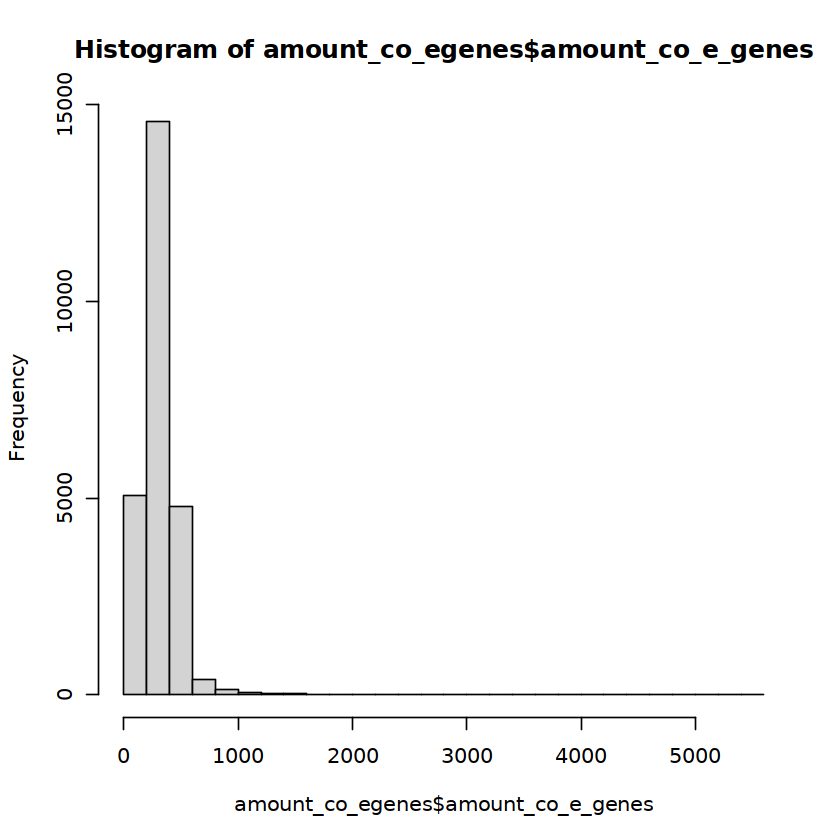

In [275]:
hist(amount_co_egenes$amount_co_e_genes, breaks = 25)

In [276]:
### Save for usage in enrichment analysis

In [277]:
## Check co-eGenes

In [278]:
head(sign_results,2)

cell_type,dataset,feature_id,snp_id,p_value,beta,beta_se,empirical_feature_p_value,feature_chromosome,feature_start,⋯,gene2,is_rb_mt,amount_tests_eGene,p_val_mt_eGene,p_bh_cutoff,p_q_cutoff,type,amount_tests_datasets,p_val_mt,p_val_corrected
<chr>,<chr>,<chr>,<chr>,<dbl>,<lgl>,<lgl>,<lgl>,<int>,<int>,⋯,<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<dbl>
CD4_T,oneK1K,A1BG_A2M,12:8942630:T:C,0.015607427,NA,NA,NA,12,9067664,⋯,A1BG,0,97356,1519.477,0.00266828,0.00266828,unique,149856468,2338874,0.8627429
CD4_T,oneK1K,A1BG_A2M,12:8971336:T:C,0.001673528,NA,NA,NA,12,9067664,⋯,A1BG,0,97356,162.928,0.00266828,0.00266828,unique,149856468,250789,0.5682995


In [279]:
#sign_results$co_egene = sign_results$gene1
#sign_results$co_egene[ sign_results$gene1 ==  sign_results$egene] = sign_results$gene2[ sign_results$gene1 ==  sign_results$egene]

In [280]:
amount_egenes = sign_results %>% group_by(coeGene) %>% summarise(amount_e_genes = n())

In [281]:
unique(amount_egenes$amount_e_genes)

[1]  979    4    1 1295    5    9    8 1030 1136 1068  941 1006 1104 1031  905
 [16]  994 1123 1059  968  893    2    3 1107 1077 1067  899  930 1004 1131  985
 [31] 1001 1170 1097 1185 1053 1099 1148 1023 1086 1024  977  955 1069 1138  993
 [46] 1019 1152  973  980 1062 1071 1014 1005  925  944  884  950  998 1092  984
 [61] 1203  987  952 1082 1095  967 1188  978 1054 1090 1040 1017 1042 1037  991
 [76] 1642 1298  909 1330 1394  927 1114 1215 1021 1043 1064 1039 1110 1063 1051
 [91] 1034 1016 1196 1429 1098 1044 1085  947  960 1010  896 1151  958 1032  990
[106] 1366 1055  989 1156  887 1025 1057 1362  901  942 1190 1206  836 1020 1012
[121]  914 1205 1027 1089  915 1002  854  935 1210 1079 1094  969 1580 1124  986
[136] 1375 1112  964  982 1448  857 1022  988 1382 1239 1102 1070 1165 1041  992
[151]  949  932 1153  966  983 1084 1049 1081 1045  902  956 1008 1140 1052 1276
[166]  981 1116 1091 1126  962 1046 1252 1007  936 1296 1324  974 1000 1080  929
[181] 1038 1061  965 1179 1011 1378 1111 1293  894 1228  918 1113 1076    6  945
[196] 1047 1159 1604 1679 1088 1177  963 1143  999 1115 1173 1181 1139 1066 1481
[211] 1227  891 1060 1029 1199 1033  948 1200 1015 1279 1075  895 1447 1230 1233
[226] 1180  970 1072 1065 1363 1050 1261 1254 1158 1035 1118  919 1087 1226 1026
[241]  838 1175  953 1169 1191 1167 1003 1133 1162 1146  959 1141 1018  934 1157
[256] 1357 1288 1127  910 1048 1145 1128 1163 1083 1056 1101 1103  937  877  976
[271]  853  946 1197 1105 1236 1287  939 1168 1498 1465 1223 1172 1120 1074 1474
[286] 1547 1160 1096 1164  933 1121 1119 1255  997 1186 1058  996 1688  903 1009
[301]  931 1797 1800 1073 1335 1161  878 1108 1251 1356  922 1411  954 1238  904
[316] 1142 1117  908  972  995 1078 1201 1442 1421 1109 1132  975 1507 1135 1272
[331] 1321  961 1454  851 1187 1093 1385    7  924 1212 1379 1192 1147 1309 1280
[346] 1313 1270 1013 1391 1209 1129  885 1106  928 1122  890 1331 1130 1028 1182
[361] 1818 1513 1371 1224   20 1625 1264 1241 1155 1183 1229  943 1297 1446 1267
[376] 1416 1253   22 1388 1225 1675 1250  971 1150 1216 1189 1231 1381  872  951
[391] 1036  957 1194 1312  889  940 1100 1340 1306 1214  912 1374 1609  875 1283
[406] 1333 1220   12   10   13   23   32   92   17 1198  898 1351  803 1234  823
[421] 1494 1380 1432  856 1176 1840  792   26   11   24   15 1530 1144 1305 1193
[436] 1125 1207  892 1645  850  858 1137  886 1242 1219 1232 1149   16  938  926
[451]  906 1154 1243  923 1222 1337  879 1218 1316  920 1486 1235 1178 1211 2039
[466] 1920 1595 2198 1493 1278 1277 1584 1311 1263 1166 1271  913  869 1523 1256
[481] 1134  897  921  804 1315 1365  888 1221  917 1257 1204 1497 1933 1329  900
[496] 1262 1367 1830 1395   28 1392 1463 1208 1760 1317 1396 1302 1314 1171 1341
[511] 1944 1328  873  845 1258  863  882  809   14  916  860 1247 1237 1470 1291
[526] 1346 1286 1213 1195 1460 1303   18   29   72   27   64   88   84   71  128
[541]   42 1561 1259   50   61  799  911 1525 1528 1174  867 1399 1301 1753  876
[556] 1184 1290 1849 1352 1482  865 1544 1846  859 1327  835 1217 1559 1639 1282
[571] 1304 1417 1275 1655 1345 1821 1358 1319 1731 1342  868 1701 1273  907 1202
[586] 1377 1441 1405 1796 1586 1274 1433  840 1410  846 1420 1443 1400 1402 1499
[601] 1246 1350 1453 1336 1869 1777 1424 1289 1372 1338 1853  844  861 1673 1496
[616] 1779 1249 1412 1344 1413 1509 1503 1368  880 1552 1549 1650 1445 1323 1628
[631] 1269  839 1562 1347 1738 1641 1475  871 1244 1308 1318 1383 1810 1542 1369
[646]  881 1320 1370 1245 1349  784  870  832 1491 2104 2109 2096 2035 2254 2057
[661] 1982 2047 2020 2008 2054 2088 2263 1962 1761 1825 2031 1882 1998 1925 1914
[676] 2159 2155 2258 2144 1886 2108 1980 1867 1415 2026 1967 2076 2024 2033 2081
[691] 1764 2053 1778 1879 2177 1722 1971 2136 1928 1637 2195 2218 2291 2007 2203
[706] 2106 1976 2114 2030 2015 2065 2137 2111 1427 2236 2141 2038 2190 2222 2021
[721] 2044 2205 1861 2099 1831 1724 1783 2131 1476 1461 1414 1408 1457 1248 1348
[736] 1725 1281 1260 1480  842 13

In [282]:
head(amount_egenes %>% arrange(-amount_e_genes),10)

coeGene,amount_e_genes
<chr>,<int>
RPS14,2291
RPL21,2263
RPL32,2258
RPL13,2254
RPL31,2254
RPS27,2236
RPS3A,2222
RPS13,2218
RPS6,2205


In [283]:
## Analyze only for egene/ co-egene pairs
analysis = unique(sign_results[,c('gene1', 'gene2', 'eGene', 'coeGene')])

In [284]:
amount_egenes = analysis %>% group_by(coeGene) %>% summarise(amount_e_genes = n())

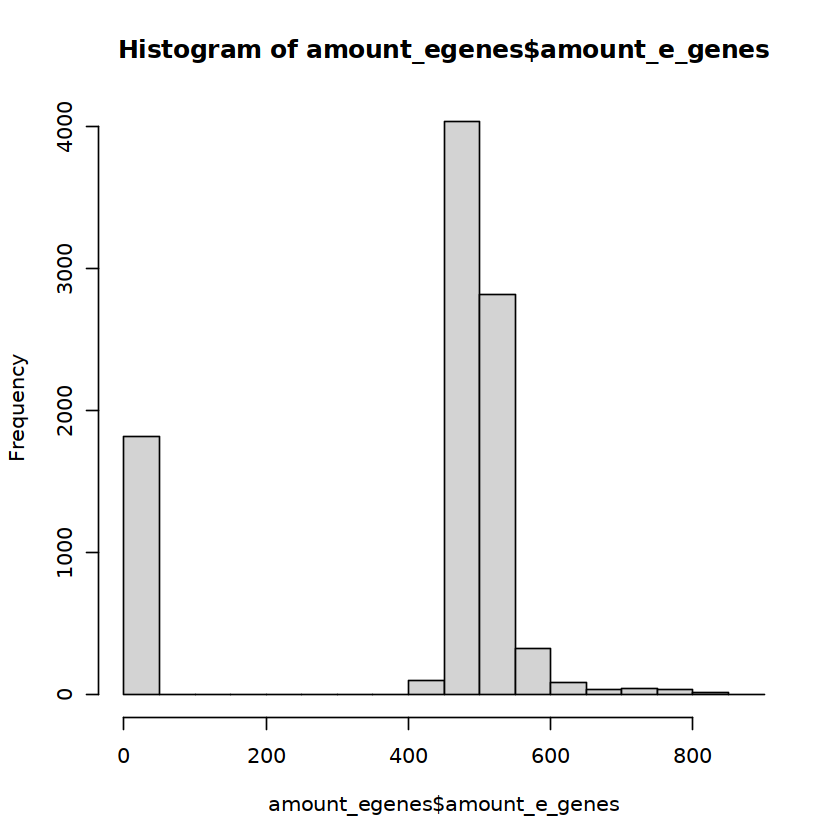

In [285]:
hist(amount_egenes$amount_e_genes, breaks = 20)

In [286]:
## Save to use as input for enrichment analysis

In [287]:
head(sign_results,2)

cell_type,dataset,feature_id,snp_id,p_value,beta,beta_se,empirical_feature_p_value,feature_chromosome,feature_start,⋯,gene2,is_rb_mt,amount_tests_eGene,p_val_mt_eGene,p_bh_cutoff,p_q_cutoff,type,amount_tests_datasets,p_val_mt,p_val_corrected
<chr>,<chr>,<chr>,<chr>,<dbl>,<lgl>,<lgl>,<lgl>,<int>,<int>,⋯,<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<dbl>
CD4_T,oneK1K,A1BG_A2M,12:8942630:T:C,0.015607427,NA,NA,NA,12,9067664,⋯,A1BG,0,97356,1519.477,0.00266828,0.00266828,unique,149856468,2338874,0.8627429
CD4_T,oneK1K,A1BG_A2M,12:8971336:T:C,0.001673528,NA,NA,NA,12,9067664,⋯,A1BG,0,97356,162.928,0.00266828,0.00266828,unique,149856468,250789,0.5682995


In [288]:
colnames(sign_results)

[1] "cell_type"                 "dataset"                  
 [3] "feature_id"                "snp_id"                   
 [5] "p_value"                   "beta"                     
 [7] "beta_se"                   "empirical_feature_p_value"
 [9] "feature_chromosome"        "feature_start"            
[11] "feature_end"               "ENSG"                     
[13] "alpha_param"               "beta_param"               
[15] "eGene"                     "coeGene"                  
[17] "coQTL"                     "snp_position"             
[19] "closeGenes"                "z_score"                  
[21] "triplet"                   "n_samples"                
[23] "n_e_samples"               "gene1"                    
[25] "gene2"                     "is_rb_mt"                 
[27] "amount_tests_eGene"        "p_val_mt_eGene"           
[29] "p_bh_cutoff"               "p_q_cutoff"               
[31] "type"                      "amount_tests_datasets"    
[33] "p_val_mt"                  "p_val_corrected"

In [289]:
#unique(sign_results$p_bh_cutoff)

In [290]:
write.csv(sign_results, paste0(result_path_analysis, 'F3_Co_E_Genes', n_sample_filter  , '_', snp_filter,  '.csv'))

In [291]:
result_path_analysis

[1] "../data/current/coeqtl_mapping/co_qtls_decision_tree/analysis_oneK1K/CD4_T/"

In [292]:
nrow(sign_results)

[1] 8050384

## Save processed co-eQTL testing file for further analysis 

In [3]:
### In the initial mapping the output of this was used as decision tree input, filename is a relict of this

In [294]:
### save as decision tree input
write.csv(coeqtl_results,  gzfile(paste0(data_path, coeqtl_results_path , '/', dataset, '/', cell_type, '/F3_decision_tree_input.csv.gz')))

In [296]:
### Prepare dummy empty correlation stats

In [297]:
file.exists(paste0(result_path_analysis , 'F6_Correlation_Summary_Stats_all.csv'))

[1] TRUE

In [298]:
cor_stats = data.frame(gene_pair = unique(coeqtl_results$feature_id),
                       mean_correlation = 0,
                       mean_abs_correlation = 0,
                       var_correlation = 0,
                       max_correlation = 0,
                       n_NA = 0,
                       n_not_NA = 0,
                       n_significant = 0, 
                       weighted_variance = 0,
                       perc_significant = 0,
                       weighted_var_div_mean = 0)

In [299]:
paste0(result_path_analysis , 'F6_Correlation_Summary_Stats_all.csv')

[1] "../data/current/coeqtl_mapping/co_qtls_decision_tree/analysis_oneK1K/CD4_T/F6_Correlation_Summary_Stats_all.csv"

In [300]:
### save as decision tree input
if(!file.exists(paste0(result_path_analysis , 'F6_Correlation_Summary_Stats_all', '_', snp_filter, '.csv'))){
    write.csv(cor_stats,  paste0(result_path_analysis , 'F6_Correlation_Summary_Stats_all', '_', snp_filter, '.csv'))
    }